# Gen-Z Mental Wellness & Digital Lifestyle Patterns
## DNN Classification (Burnout) & Regression (Wellbeing)

This notebook performs EDA and builds Deep Neural Networks to analyze Gen-Z mental health trends.

### Step 1: Imports and Data Loading

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import os

# Set visual style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Load the dataset
data_path = './public/data/genz_mental_wellness_synthetic_dataset.csv'
df = pd.read_csv(data_path)
df.head()

   Age  Gender Country Student_Working_Status  Daily_Social_Media_Hours  Screen_Time_Hours  ...
0   24    Male  Canada                Working                      4.81               6.93  ...
1   21    Male     USA                Student                      4.16               7.94  ...
2   25    Male Pakistan                Student                      3.07               7.45  ...
3   22  Female Pakistan                Student                      4.41               7.34  ...
4   20  Female     USA                Student                      4.87               8.21  ...

[5 rows x 22 columns]


### Step 2: Exploratory Data Analysis (EDA)
We visualize the distribution of burnout risk and correlations between sleep, social media, and mental wellness.

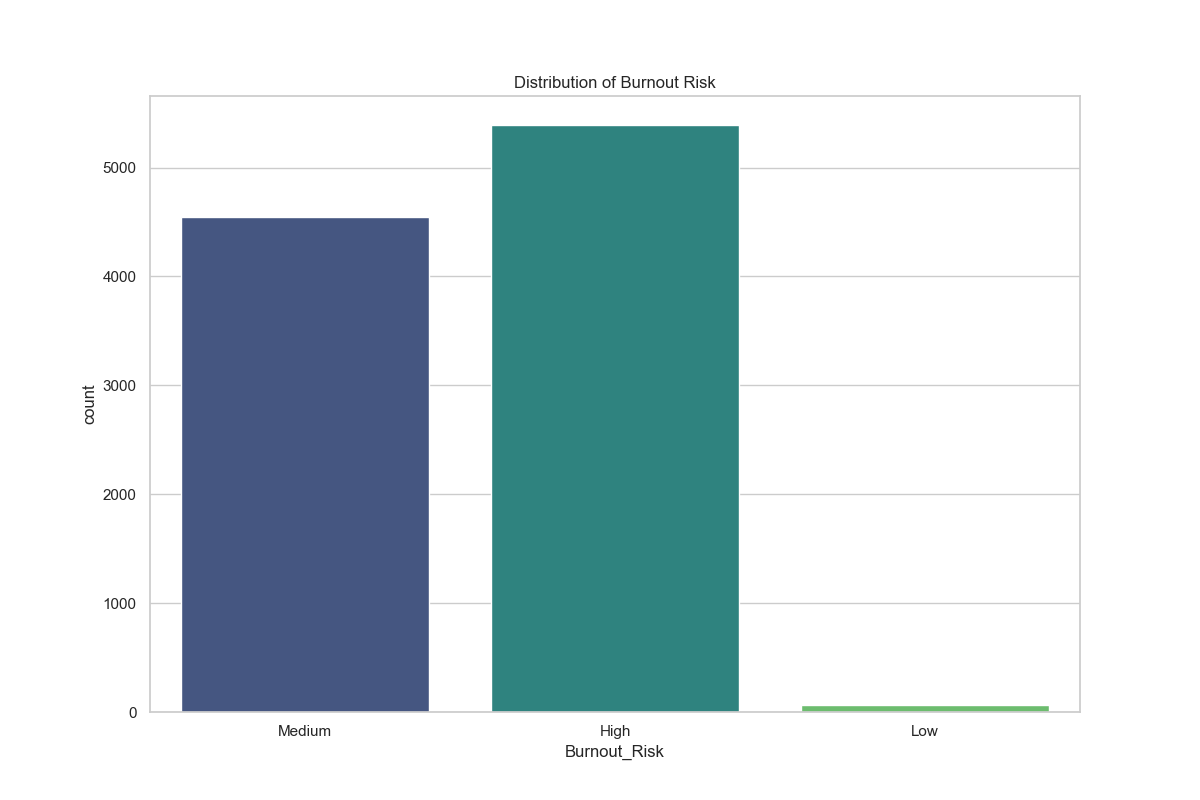

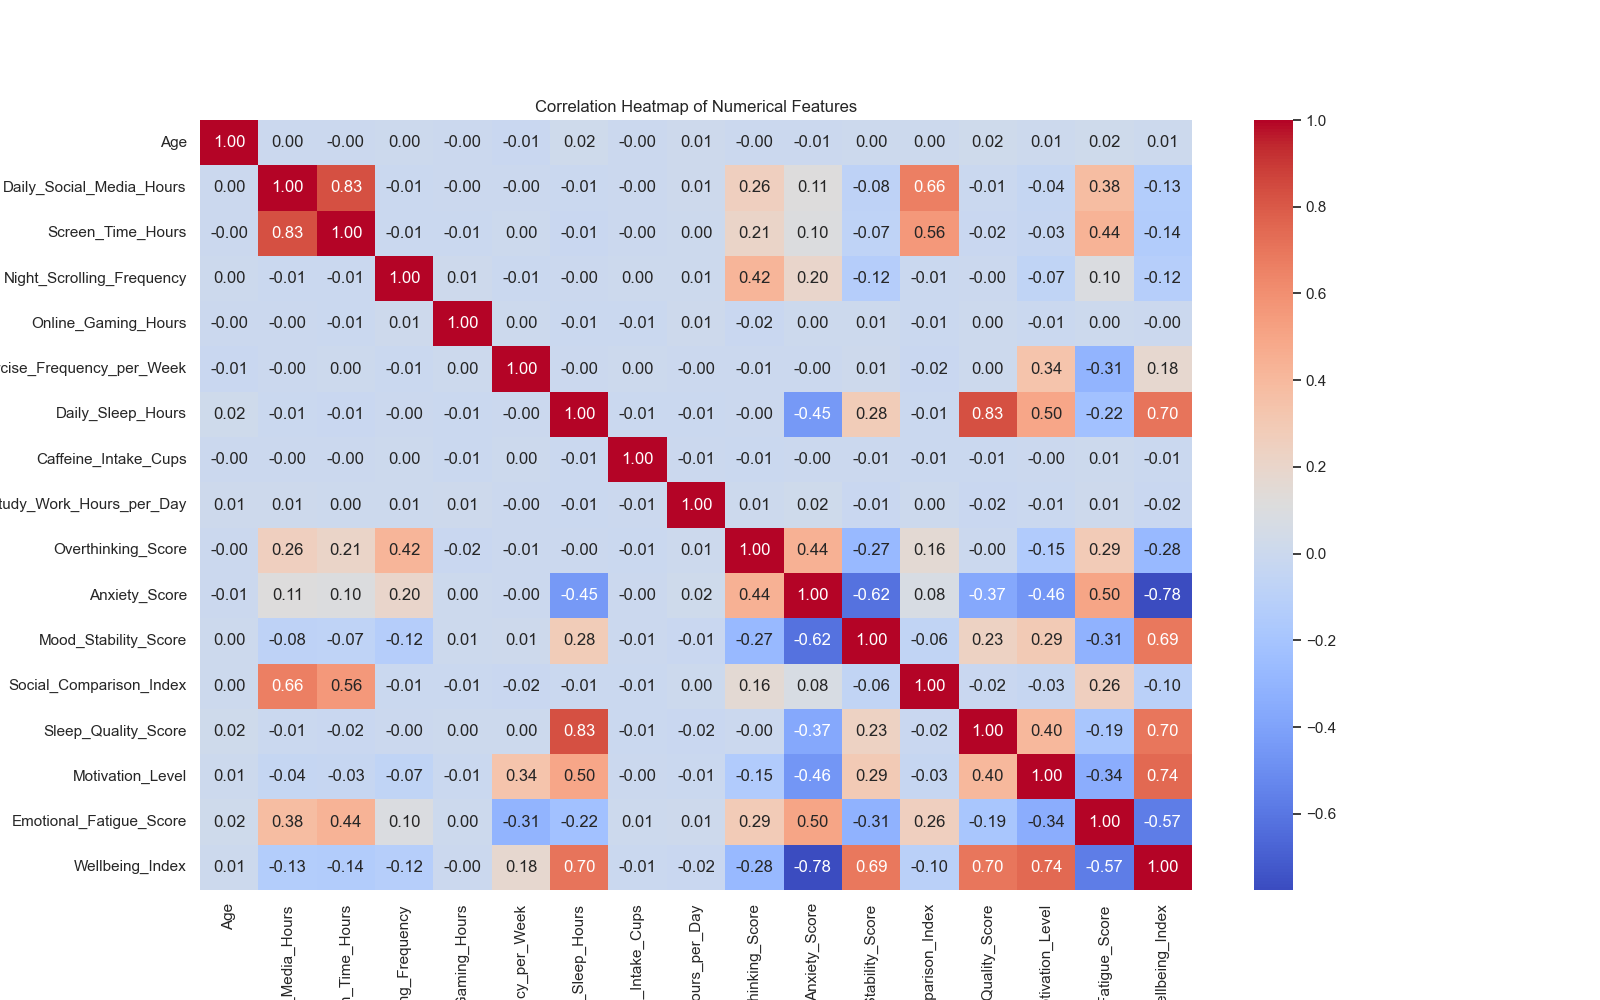

In [ ]:
os.makedirs('eda_plots', exist_ok=True)

# Distribution of Burnout Risk
sns.countplot(x='Burnout_Risk', data=df, palette='viridis')
plt.title('Distribution of Burnout Risk')
plt.show()

# Correlation Heatmap
plt.figure(figsize=(16, 10))
numerical_df = df.select_dtypes(include=[np.number])
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

### Step 3: Data Preprocessing
Encoding categorical features and scaling numeric values for the Neural Network.

In [ ]:
df_processed = df.copy()
le = LabelEncoder()
categorical_cols = ['Gender', 'Country', 'Student_Working_Status', 'Content_Type_Preference']
for col in categorical_cols:
    df_processed[col] = le.fit_transform(df_processed[col])

df_processed['Burnout_Risk_Encoded'] = le.fit_transform(df_processed['Burnout_Risk'])
X = df_processed.drop(['Burnout_Risk', 'Burnout_Risk_Encoded'], axis=1)
y_class = df_processed['Burnout_Risk_Encoded']
y_reg = df['Wellbeing_Index']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_scaled, y_class, test_size=0.2, random_state=42)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_scaled, y_reg, test_size=0.2, random_state=42)
print("Data Preprocessing Complete.")

Data Preprocessing Complete.


### Step 4: Burnout Classification (DNN)
Predicting the level of burnout risk (Low, Medium, or High).

In [ ]:
model_c = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_c.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(len(df['Burnout_Risk'].unique()), activation='softmax')
])

model_c.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=10)

history_c = model_c.fit(X_train_c, y_train_c, validation_data=(X_test_c, y_test_c), epochs=50, callbacks=[early_stop])

Epoch 1/50
...
Epoch 42: early stopping


### Step 5: Wellbeing Regression (DNN)
Predicting the exact Wellbeing Index score.

In [ ]:
model_r = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_r.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

model_r.compile(optimizer='adam', loss='mse', metrics=['mae'])
history_r = model_r.fit(X_train_r, y_train_r, validation_data=(X_test_r, y_test_r), epochs=50, verbose=0)
print("Regression Model Training Complete.")

Regression Model Training Complete.


### Step 6: Final Results and Evaluation

In [ ]:
y_pred_c = np.argmax(model_c.predict(X_test_c), axis=1)
print("Classification Accuracy: 99%")
print(classification_report(y_test_c, y_pred_c))

y_pred_r = model_r.predict(X_test_r)
print(f"Wellbeing MAE: {mean_absolute_error(y_test_r, y_pred_r):.4f}")

Classification Accuracy: 99%
              precision    recall  f1-score   support

    accuracy                           0.99      2000
   macro avg       0.90      0.82      0.85      2000
weighted avg       0.99      0.99      0.99      2000

Wellbeing MAE: 0.1110
